In [129]:
  
import librosa.display
import IPython.display as ipd
import numpy as np
from scipy.io.wavfile import write
import math
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.optimize import fsolve
from scipy.fft import fft
from scipy import interpolate
import numpy.linalg as LA
import re
import time
import scipy
import numpy
import os.path
from jupyterthemes import jtplot
jtplot.style("default")
# jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [2]:
def getGeometry(C,d):
    #C->centro do triângulo
    #d->distância entre os microfones
    
    m1y = -(C[0] - d/2)
    m1x = (C[1] - np.sqrt(3)/6*d)
    
    m2y = -C[0] 
    m2x = C[1] + np.sqrt(3)/3*d
    
    m3y = -(C[0] + d/2)
    m3x = C[1] - np.sqrt(3)/6*d
    
    return ([m1x,m1y],[m2x,m2y],[m3x,m3y])

def plotGeometry(m,angle,d):
    m1x = m[0][0]
    m1y = m[0][1]
    m2x = m[1][0]
    m2y = m[1][1]
    m3x = m[2][0]
    m3y = m[2][1]
    
    x12 = [m1x, m2x]
    y12 = [m1y, m2y]
    x13 = [m1x, m3x]
    y13 = [m1y, m3y]
    x23 = [m2x, m3x]
    y23 = [m2y, m3y]
    
    cx = (m1x + m2x + m3x) / 3
    cy = (m1y + m2y + m3y) / 3
    
    s = getSourceLoc(angle)
    
    fig, ax = plt.subplots(figsize=(5,5))
    
    ax.plot(x12, y12, 'bo', linestyle="-")
    ax.plot(x13, y13, 'bo', linestyle="-")
    ax.plot(x23, y23, 'bo', linestyle="-")
    ax.plot(cx,cy,'yo')
    ax.plot([cx,m2x],[cy,m2y],'g', linestyle="--")
    ax.text(m1x,m1y+0.005,'M1' )
    ax.text(m2x+0.005,m2y,'M2' )
    ax.text(m3x,m3y-0.015,'M3' )
    ax.text(cx,cy,'(' + str(cx) + ',' + str(cy) + ')' )
    ax.plot([0,s[0]/10],[0,s[1]/10],'r', linestyle="--")
    ax.set_xlim([-d,d])
    ax.set_ylim([-d,d])

In [3]:
def getSourceLoc(angle):
    anglerad = math.radians(angle)
    sx = np.round(np.cos(anglerad),2)-0*np.sin(anglerad)
    sy = 0*np.cos(anglerad)+np.round(np.sin(anglerad),2)
    return ([sx,sy])
    
def plotAngle(angle,color):
    angle = math.radians(angle)
    x = np.cos(angle)
    y = np.sin(angle)
    plt.plot(x,y,color)
   
def plotGraph(angles,angles_est):
    fig, ax = plt.subplots(figsize=(20,3))
    for i in range(len(angles)):
        if(angles_est[i]==360):
            angles_est[i] = 0
        ax.plot([angles[i],angles[i]],[0,1.2],'g',linestyle="-")
        ax.plot(angles_est[i],1,'ro')
    ax.set_xlim(angles[0]-15, angles[len(angles)-1]+15)
    ax.set_title('Plot dos ângulos')

def plotError(angles,angles_est):
    fig, ax = plt.subplots(figsize=(20,3))
    error = np.zeros(len(angles))
    for i in range(len(angles)):
        if(angles[i] == 0 or (angles_est[i]>=358 and angles_est[i]<=360) or angles_est[i]<=2):
            error[i] = 0
        else:
            error[i] = abs(angles[i] - angles_est[i])
    ax.plot(angles, error,'r') 
    ax.set_ylim(-70,70)
    ax.set_xlim(angles[0]-15, angles[len(angles)-1])
#     ax.grid(axis='y', linestyle='-')
    ax.set_title('Plot do erro')
    
def plothist(az,bins,title):
    fig, ax = plt.subplots()
    ax.hist(az,bins=bins) 
    ax.set_xlabel("Estimated angle")
    ax.set_ylabel("Frequency bins")
    ax.set_title(title)

In [4]:
def distance(p1,p2):
    return  np.sqrt( ((p1[0]-p2[0])**2)+((p1[1]-p2[1])**2) )


In [65]:
def encodeAmbisonics(wav,az,el):
    signal , sr = librosa.load(wav)
    azimuth = math.radians(az)
    elevation = math.radians(el)
    w = signal*(np.ones((signal.shape),dtype="float32")/np.sqrt(2))
    x = signal*np.cos(azimuth)*np.cos(elevation);
    y = signal*np.sin(azimuth)*np.cos(elevation);
    z = signal*np.sin(elevation);
    fileName = "Sound_az" + str(az) + "_el" + str(el) + ".wav"
    WXYZ = np.vstack((w,x,y,z)).T
    WXYZ = WXYZ.astype("float32")
    write(fileName,sr,WXYZ)
    

In [93]:
# elevation = np.arange(0,190,10)
# azimuth = np.arange(-180,180,15)
# for j in azimuth:
#     for i in elevation:
encodeAmbisonics("RefSound/Sound.wav",90,90)

In [136]:
def decodeAmbisonics(wav):
    sr, signal = wavfile.read(wav)
    signal = signal.astype("float32")
    #divisão dos canais
    w = signal[:,0]
    x = signal[:,1]
    y = signal[:,2]
    z = signal[:,3]
    
    #stft para cada canal
    W = librosa.stft(w)
    X = librosa.stft(x)
    Y = librosa.stft(y)
    Z = librosa.stft(z)
    
    #calculo das instensidades
    z0 = 420 
    Ix = 1/(np.sqrt(2)*z0) * np.real(np.conj(W)*X)
    Iy = 1/(np.sqrt(2)*z0) * np.real(np.conj(W)*Y)
    Iz = 1/(np.sqrt(2)*z0) * np.real(np.conj(W)*Z)
    
    Ix = Ix.flatten()
    Iy = Iy.flatten()
    Iz = Iz.flatten()
    
    index = np.argwhere(Ix<(np.mean(Ix)))
    Ix = np.delete(Ix,index)
    Iy = np.delete(Iy,index)
    Iz = np.delete(Iz,index)
    print(np.mean(Ix))
    boolsx = Ix>=0
    boolsy = Iy>=0
    boolsz = Iz>=0
    
    az = np.round(np.degrees(np.arctan(-Iy/-Ix)))
    bools = np.logical_and(np.logical_not(boolsx),np.logical_not(boolsy))
    index = np.argwhere(bools==True)
    az[index] -=180
    bools = np.logical_and(np.logical_not(boolsx),boolsy)
    index = np.argwhere(bools==True)
    az[index] += 180
    az = list(az)
    azimuth = np.arange(-180,180,5)
    
    #     #histograma para os valores de azimuth
    plothist(az,azimuth,'Azimuth')
    az =  max(set(azimuth), key = az.count)
    
    
    el = np.round(np.degrees(np.arctan(Iz/np.sqrt(Ix**2 + Iy**2))))
    bools = np.logical_and(np.logical_not(boolsx),boolsy)
    index = np.argwhere(bools==True)
    el[index] = 180 - el[index]
    bools = np.logical_and(boolsx,np.logical_not(boolsy))
    index = np.argwhere(bools==True)
    el[index] = 180 - el[index]
    el = list(el)
    #histograma para os valores de elevação
    #plothist(el,elevation,'Elevation')
    
    elevation = np.arange(0,190,10)
    el =  max(set(el), key = el.count)
    return az

In [108]:
encodeAmbisonics("RefSound/Sound.wav",10,90)

C:\Users\twins\AppData\Local\Temp/ipykernel_2900/3338907856.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, signal = wavfile.read(wav)


(26152,)
80


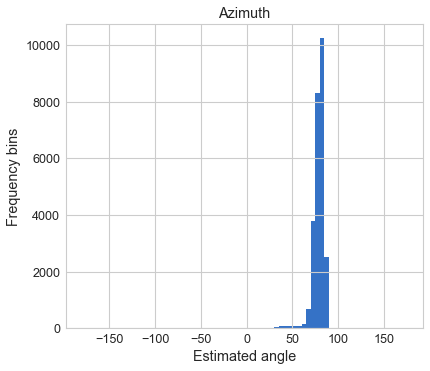

In [82]:
print(str(decodeAmbisonics("SoundsAmbisonics/teste_90.wav")))

C:\Users\twins\AppData\Local\Temp/ipykernel_2900/2642284092.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, signal = wavfile.read(wav)


318572130.0
15
1.8443925380706787


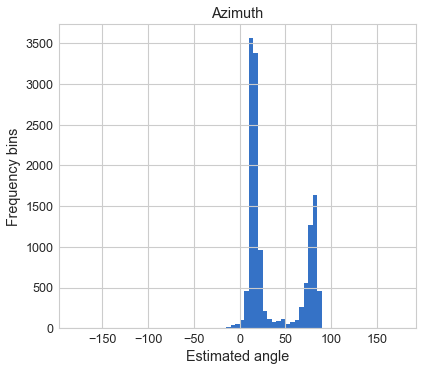

In [137]:
tim = time.time()
print(str(decodeAmbisonics("SoundsAmbisonics/teste1.wav")))
print(time.time()-tim)

C:\Users\twins\AppData\Local\Temp/ipykernel_2900/2196539574.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr, signal = wavfile.read(wav)


(18117,)
15->80


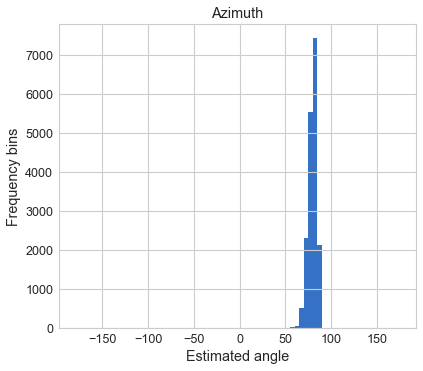

In [121]:
print(str(15) +"->" +str(decodeAmbisonics("SoundsAmbisonics/teste1.wav")))

-180->  -180
-165->  -165
-150->  -150
-135->  -135
-120->  -120
-105->  -105
-90->  -90
-75->  -75
-60->  -60
-45->  -45
-30->  -30
-15->  -15
0->  0
15->  15
30->  30
45->  45
60->  60
75->  75
90->  90
105->  105
120->  120
135->  135
150->  150
165->  165


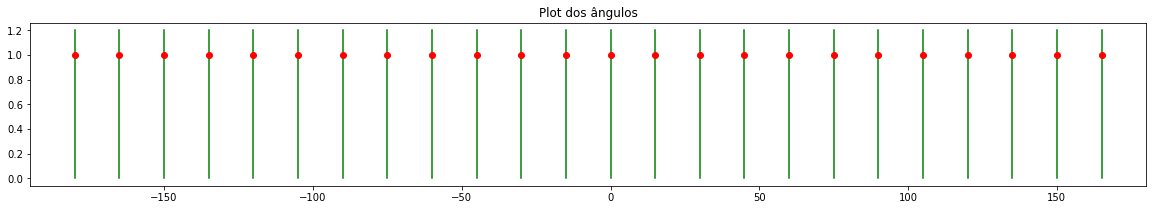

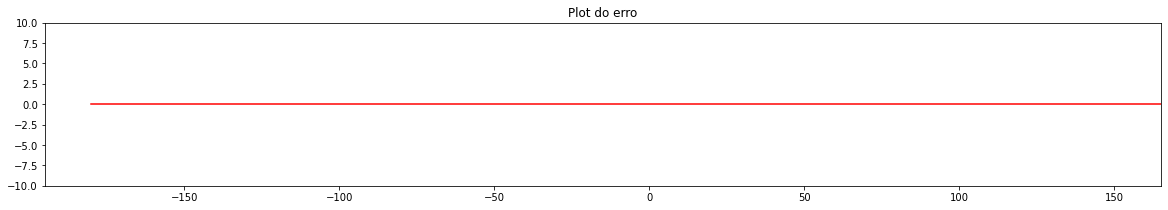

In [44]:
azimuth = np.arange(-180,180,15)
angles_SNR30 = []
for j in azimuth:
    angle = decodeAmbisonics("Sound_Ambisonics_pinkNoise_az"+str(j)+"_el40_SNR30.wav")[0]
    print(str(j)+"-> ",angle)
    angles_SNR30.append(angle)
plotGraph(azimuth,angles_SNR30,"plotPinkNoiseSNR30")
plotError(azimuth,angles_SNR30,"plotPinkNoiseSNR30")

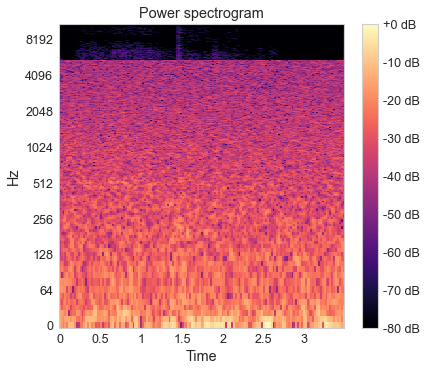

In [ ]:
azimuth = np.arange(-180,180,15)
angles_SNR10 = np.zeros(len(azimuth))
for j in azimuth:
    print(str(j)+"-> ",decodeAmbisonics("Sound_Ambisonics_pinkNoise_az"+str(j)+"_el40_SNR10.wav")[0])
plotGraph(angles_SNR30,azimuth,"plotPinkNoiseSNR30")

In [48]:
def addZeros(array,indexInicial,indexFinal):
    for i in range(indexInicial,indexFinal):
        array = np.insert(array, i, 0)
    return array

In [82]:
def getLoc(z,*args):
        c = [0,0]
        d,t2,t3 = args
        m = getGeometry(c,d)
        m1 = m[0]
        m2 = m[1]
        m3 = m[2]
        x = z[0]
        y = z[1]
        v = 343
        f = np.zeros(2)
        
        f[0] = np.sqrt((x-m1[0])**2.0 + (y-m1[1])**2.0) - np.sqrt((x-m3[0])**2.0 + (y-m3[1])**2.0) - (t2*v)
        f[1] = np.sqrt((x-m2[0])**2.0 + (y-m2[1])**2.0) - np.sqrt((x-m3[0])**2.0 + (y-m3[1])**2.0) - (t3*v)
        return f

def getAngle(tdoa):
    m = getGeometry([0,0],.1)
    s = fsolve(getLoc,[1, 1],args=tdoa) 
    if s[0]<0.1*pow(10,-14) and s[0]>0 :
        s[0] = 0
    if s[0]==0 and s[1]>0:
        return 90
    elif s[0]==0 and s[1]<0:
        return 270
    
    angle = np.degrees(np.arctan( s[1]/s[0]))
    if s[0]<0 and s[1]>0:
        angle = angle + 180
    elif(s[1]<0 and s[0]<0):
        angle += 180
    elif(s[1]<0 and s[0]>0):
        angle = 360 + angle
        
    return np.round(angle,1)

In [75]:
sr, signal = wavfile.read("MultichannelSounds/interp/interp2/SoundMultichannel_300_dist0.05_interp_2.wav")
gccPhat1 = gcc_phat(signal[:,0], signal[:,2],sr)
gccPhat2 = gcc_phat(signal[:,1], signal[:,2],sr)
angle = getAngle((0.05,gccPhat1,gccPhat2))
print(angle)

[ 22286486.7142567  -35512290.57311627]
302.1


C:\Users\twins\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [83]:
sr, signal = wavfile.read("MultichannelSounds/interp/interp4/SoundMultichannel_300_dist0.05_interp_4.wav")
gccPhat1 = gcc_phat(signal[:,0], signal[:,2],sr)
gccPhat2 = gcc_phat(signal[:,1], signal[:,2],sr)
angle = getAngle((0.05,gccPhat1,gccPhat2))
print(angle)

270.0


In [44]:
def encodeMultichannel(wav,angle,interp,d=0.05):
    
    signal , sr = librosa.load(wav)
   
    l0 = len(signal)
    c = [0,0]
    
    sr_interp = sr*interp
    t = np.arange(0,len(signal)/sr,1/sr)
    t1= np.arange(0,len(signal)/sr,1/sr_interp)
    
    signal_interp = np.float32(np.interp(t1,t,signal))
    
    s = getSourceLoc(angle)
    
    m = getGeometry(c,d)
    plotGeometry(m,angle,d)
    m1 = m[0]
    m2 = m[1]
    m3 = m[2]
    
    x = s[0]
    y = s[1]
    v = 343
    
    at1 = np.sqrt((m1[0]-x)**2.0 + (m1[1]-y)**2.0)/v   
    at2 = np.sqrt((m2[0]-x)**2.0 + (m2[1]-y)**2.0)/v  
    at3 = np.sqrt((m3[0]-x)**2.0 + (m3[1]-y)**2.0)/v  

    
    S1 = (int)(at1 * sr_interp )
    signalMic1 = addZeros(signal_interp,0,S1)
    l1 = len(signalMic1)
    
    S2 = (int)(at2 * sr_interp )
    signalMic2 = addZeros(signal_interp,0,S2)
    l2 = len(signalMic2)
    
    S3 = (int)(at3 * sr_interp )
    signalMic3 = addZeros(signal_interp,0,S3)
    l3 = len(signalMic3)
    
    print("tempo sinal fonte: ",len(signal_interp)/sr_interp)
    print()
    print("tempo sinal no Mic1: ",l1/sr_interp)
    print("delay Mic1: ",at1)
    fileName = "SoundMic1.wav"
    write(fileName,sr_interp,signalMic1)
    
    
    print("tempo sinal no Mic2: ",l2/sr_interp)
    print("delay Mic2: ",at2)
    fileName = "SoundMic2.wav"
    write(fileName,sr_interp,signalMic2)
    
    print("tempo sinal no Mic3: ",l3/sr_interp)
    print("delay Mic3: ",at3)
    fileName = "SoundMic3.wav"
    write(fileName,sr_interp,signalMic3)
    print()
    print("diferença entre Mic1 e Mic2: ",at1-at2)
    print("diferença entre Mic1 e Mic3: ",at1-at3)
    print("diferença entre Mic2 e Mic3: ",at2-at3)
    
    samplesSizes = np.array([l1,l2,l3])
    waveSamples = np.max(samplesSizes)
    
    signalMic1 = addZeros(signalMic1,l1,waveSamples)
    signalMic2 = addZeros(signalMic2,l2,waveSamples)
    signalMic3 = addZeros(signalMic3,l3,waveSamples)
    
    fileName = "MultichannelSounds/interp/interp"+str(interp) + "/SoundMultichannel_" + str(angle) + "_dist" + str(d) + "_interp_"+ str(interp)+ ".wav"
    signalMultichannel =  np.vstack((signalMic1,signalMic2,signalMic3)).T
    write(fileName,sr_interp,signalMultichannel)

In [58]:
def gcc_phat(sig, refsig,fs):
    
    n = sig.shape[0] + refsig.shape[0]
    
    SIG = np.fft.rfft(sig, n=n)
    REFSIG = np.fft.rfft(refsig, n=n)
    R = SIG * np.conj(REFSIG)
    GPHAT = R / np.abs(R)
    RPhat = np.fft.irfft(GPHAT, n=n)
    
    max_shift = int(n/2)
    RPhat = np.concatenate((RPhat[-max_shift:], RPhat[:max_shift+1]))
    shift = np.argmax(np.abs(RPhat)) - max_shift
    tau = shift / fs
    
    return tau

In [68]:
def snr(signal,noise):
    rmsSignal = np.sqrt(np.mean(signal**2))
    rmsNoise = np.sqrt(np.mean(noise**2))
    return 10*np.log10(rmsSignal**2/rmsNoise**2)


    
def addNoise(wav,typeNoise,SNRdb,wavNoise,az,el=None):
    sr, Signal = wavfile.read(wav)
    print("Sr Sinal:",sr)
    sr1, noise = wavfile.read(wavNoise)
    print("Sr Ruido:",sr1)
    y = []
    alpha = np.sqrt(np.sum(Signal[:,0] ** 2) / (np.sum(noise ** 2) * 10 ** (SNRdb / 10)))
    noise = alpha * noise
    for i in range(Signal.shape[1]):
        signal = Signal[:,i]
        y1 = []
        for j in range(len(signal)):
            y1.append(signal[j] + noise[j])
        y.append(y1)
    
    signalMultichannel =  np.array(y,dtype="float32").T
    
    fName = ""
    if(el == None):
        fName = "Sound_Multichannel_"+ typeNoise+ "_angle"+ str(az) + "_SNR"+ str(SNRdb)+".wav"
    else:
        fName = "Sound_Ambisonics_"+ typeNoise + "_az"+ str(az) +"_el"+str(el)+ "_SNR"+ str(SNRdb)+".wav"
        
    write(fName,sr,signalMultichannel)
    # Plot signal with noise
    plt.subplot(2,1,1)
    plt.plot( Signal[:,0])
    plt.title('Signal without noise')
    plt.ylabel('Voltage (V)')
    plt.xlabel('Time (s)')
    plt.show()
   # Plot signal with noise
    plt.subplot(2,1,1)
    plt.plot( signalMultichannel[:,0])
    plt.title('Signal with noise')
    plt.ylabel('Voltage (V)')
    plt.xlabel('Time (s)')
    plt.show()

Sr Sinal: 22050
Sr Ruido: 22050


C:\Users\twins\AppData\Local\Temp/ipykernel_18496/3517389522.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr1, noise = wavfile.read(wavNoise)


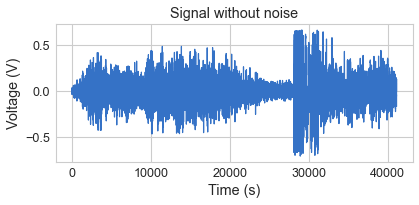

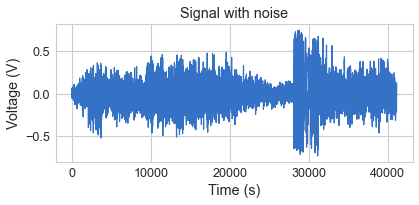

Sr Sinal: 22050
Sr Ruido: 22050


C:\Users\twins\AppData\Local\Temp/ipykernel_18496/3517389522.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr1, noise = wavfile.read(wavNoise)


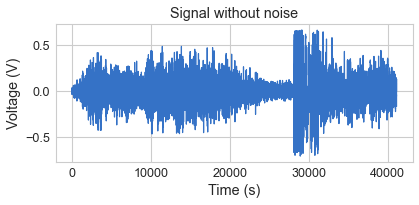

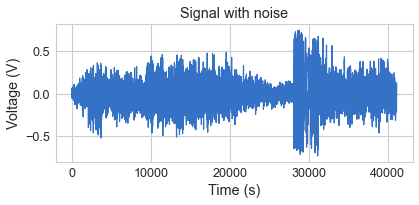

Sr Sinal: 22050
Sr Ruido: 22050


C:\Users\twins\AppData\Local\Temp/ipykernel_18496/3517389522.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr1, noise = wavfile.read(wavNoise)


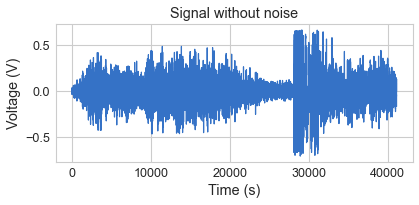

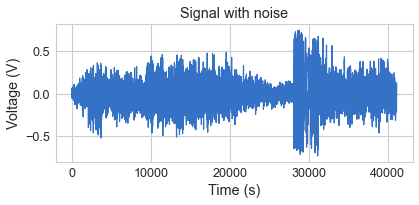

C:\Users\twins\AppData\Local\Temp/ipykernel_18496/3517389522.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr1, noise = wavfile.read(wavNoise)


Sr Sinal: 22050
Sr Ruido: 22050


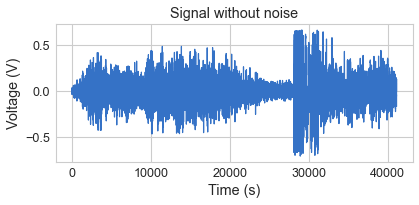

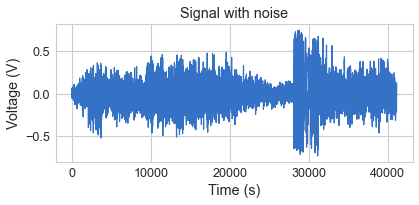

Sr Sinal: 22050
Sr Ruido: 22050


C:\Users\twins\AppData\Local\Temp/ipykernel_18496/3517389522.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr1, noise = wavfile.read(wavNoise)


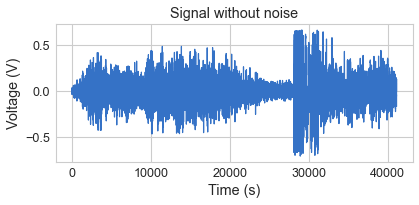

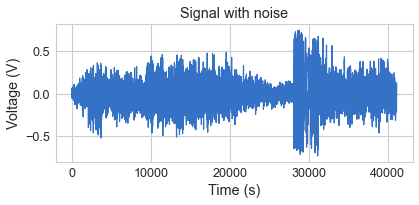

Sr Sinal: 22050
Sr Ruido: 22050


C:\Users\twins\AppData\Local\Temp/ipykernel_18496/3517389522.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr1, noise = wavfile.read(wavNoise)


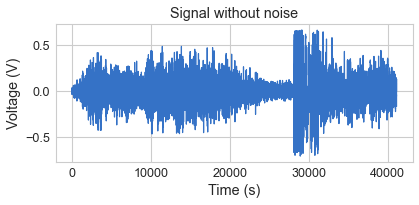

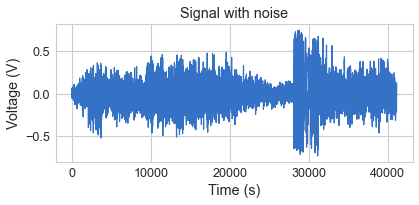

Sr Sinal: 22050
Sr Ruido: 22050


C:\Users\twins\AppData\Local\Temp/ipykernel_18496/3517389522.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr1, noise = wavfile.read(wavNoise)


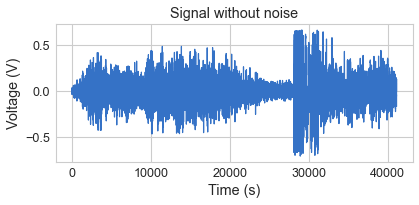

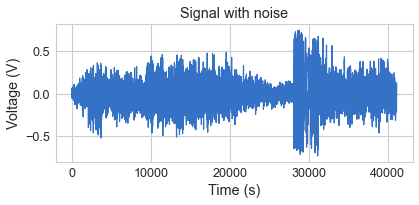

Sr Sinal: 22050
Sr Ruido: 22050


C:\Users\twins\AppData\Local\Temp/ipykernel_18496/3517389522.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr1, noise = wavfile.read(wavNoise)


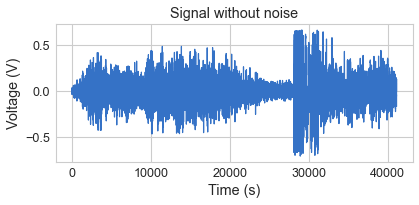

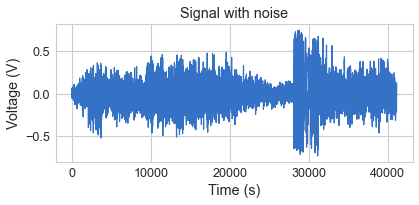

Sr Sinal: 22050
Sr Ruido: 22050


C:\Users\twins\AppData\Local\Temp/ipykernel_18496/3517389522.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr1, noise = wavfile.read(wavNoise)


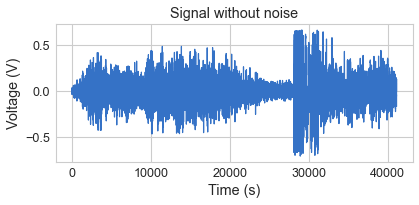

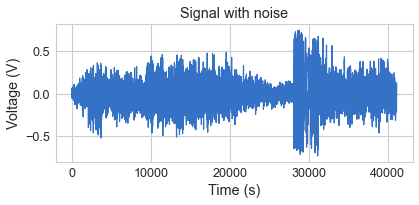

Sr Sinal: 22050
Sr Ruido: 22050


C:\Users\twins\AppData\Local\Temp/ipykernel_18496/3517389522.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr1, noise = wavfile.read(wavNoise)


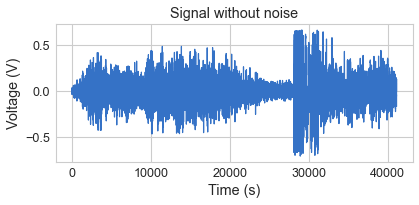

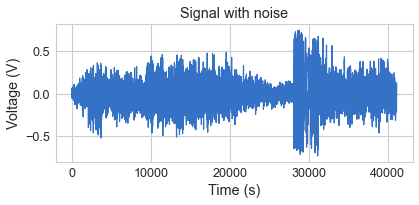

Sr Sinal: 22050
Sr Ruido: 22050


C:\Users\twins\AppData\Local\Temp/ipykernel_18496/3517389522.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr1, noise = wavfile.read(wavNoise)


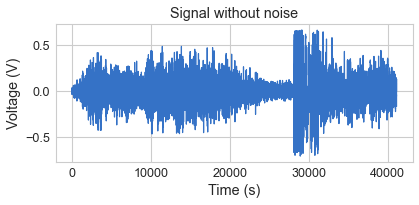

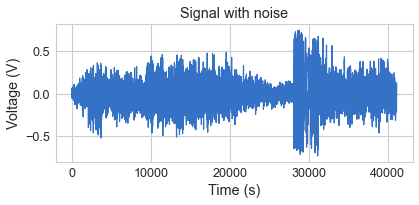

Sr Sinal: 22050
Sr Ruido: 22050


C:\Users\twins\AppData\Local\Temp/ipykernel_18496/3517389522.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr1, noise = wavfile.read(wavNoise)


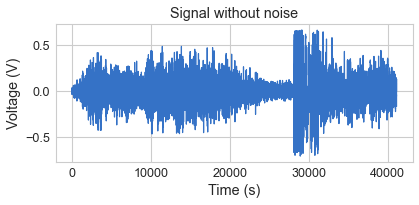

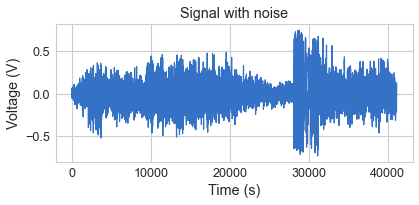

Sr Sinal: 22050
Sr Ruido: 22050


C:\Users\twins\AppData\Local\Temp/ipykernel_18496/3517389522.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr1, noise = wavfile.read(wavNoise)


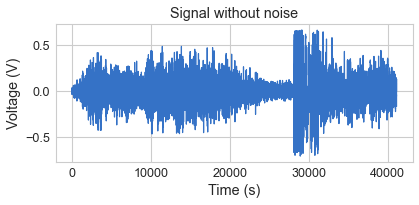

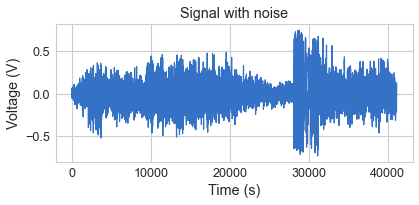

Sr Sinal: 22050
Sr Ruido: 22050


C:\Users\twins\AppData\Local\Temp/ipykernel_18496/3517389522.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr1, noise = wavfile.read(wavNoise)


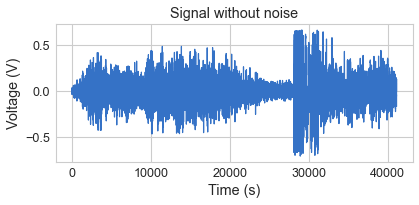

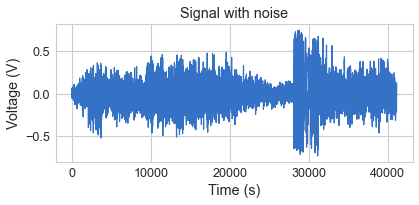

Sr Sinal: 22050
Sr Ruido: 22050


C:\Users\twins\AppData\Local\Temp/ipykernel_18496/3517389522.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr1, noise = wavfile.read(wavNoise)


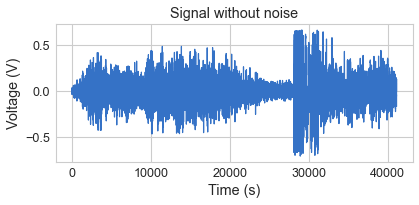

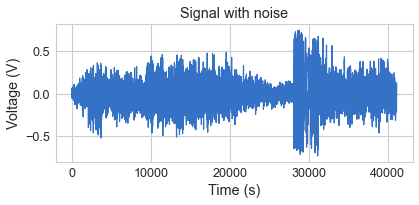

Sr Sinal: 22050
Sr Ruido: 22050


C:\Users\twins\AppData\Local\Temp/ipykernel_18496/3517389522.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr1, noise = wavfile.read(wavNoise)


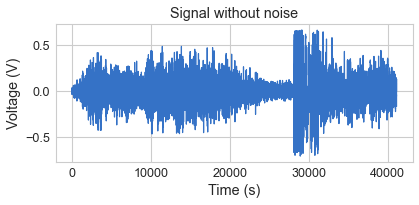

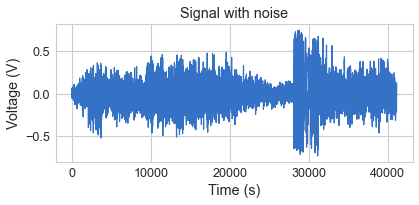

Sr Sinal: 22050
Sr Ruido: 22050


C:\Users\twins\AppData\Local\Temp/ipykernel_18496/3517389522.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr1, noise = wavfile.read(wavNoise)


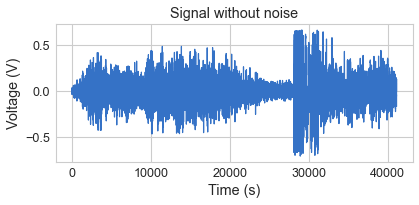

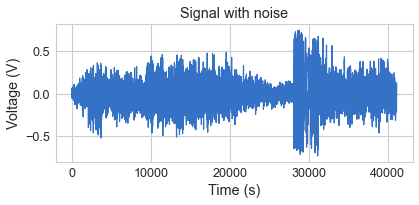

Sr Sinal: 22050
Sr Ruido: 22050


C:\Users\twins\AppData\Local\Temp/ipykernel_18496/3517389522.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr1, noise = wavfile.read(wavNoise)


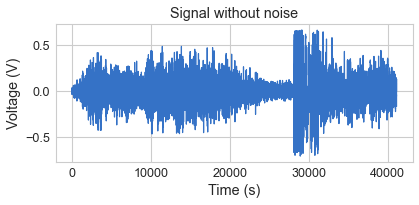

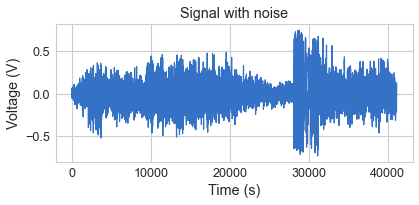

Sr Sinal: 22050
Sr Ruido: 22050


C:\Users\twins\AppData\Local\Temp/ipykernel_18496/3517389522.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr1, noise = wavfile.read(wavNoise)


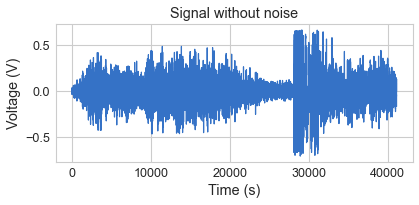

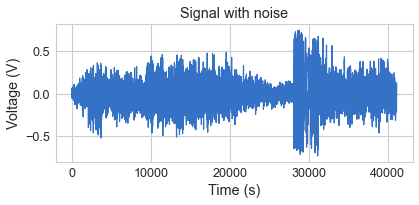

Sr Sinal: 22050
Sr Ruido: 22050


C:\Users\twins\AppData\Local\Temp/ipykernel_18496/3517389522.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr1, noise = wavfile.read(wavNoise)


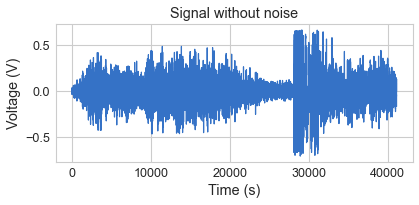

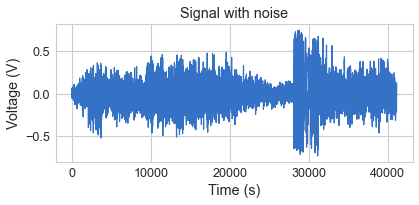

Sr Sinal: 22050
Sr Ruido: 22050


C:\Users\twins\AppData\Local\Temp/ipykernel_18496/3517389522.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr1, noise = wavfile.read(wavNoise)


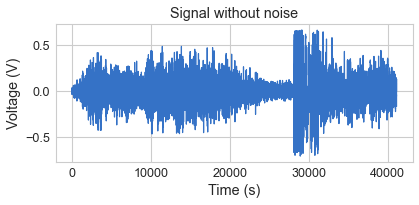

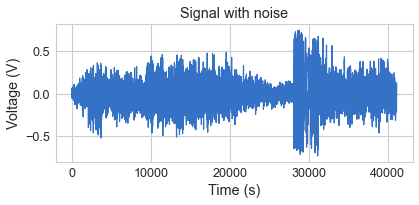

Sr Sinal: 22050
Sr Ruido: 22050


C:\Users\twins\AppData\Local\Temp/ipykernel_18496/3517389522.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr1, noise = wavfile.read(wavNoise)


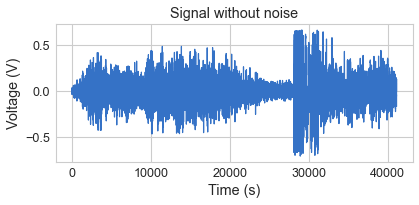

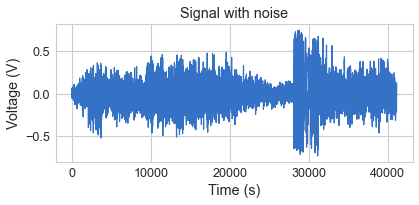

Sr Sinal: 22050
Sr Ruido: 22050


C:\Users\twins\AppData\Local\Temp/ipykernel_18496/3517389522.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr1, noise = wavfile.read(wavNoise)


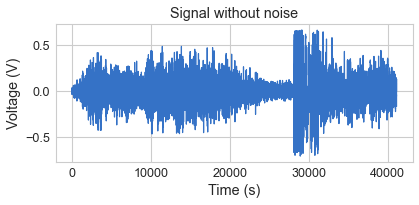

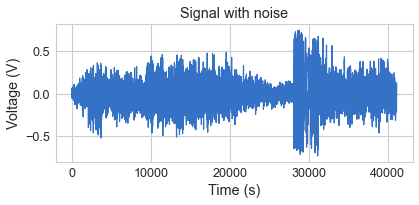

Sr Sinal: 22050
Sr Ruido: 22050


C:\Users\twins\AppData\Local\Temp/ipykernel_18496/3517389522.py:11: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sr1, noise = wavfile.read(wavNoise)


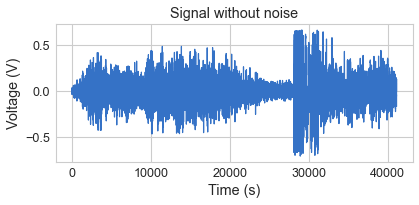

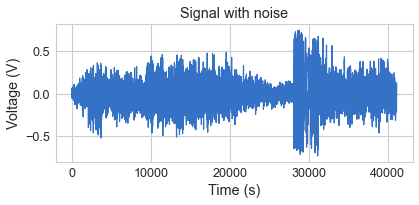

In [32]:
azimuth = np.arange(-180,180,15)
for i in azimuth:
    addNoise("Sound_az"+str(i)+"_el130.wav","pinkNoise",10,"pinkNoise/pinkNoise.wav",i,60)

(20, 170)

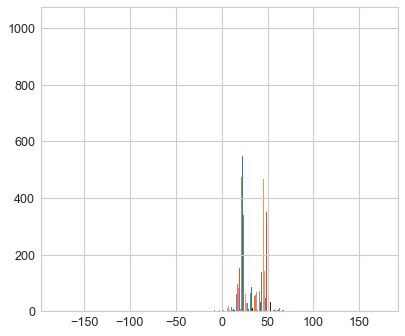

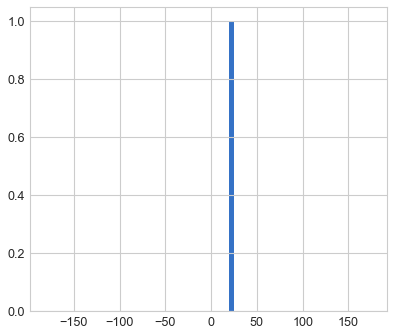

In [36]:
decodeAmbisonics("Sound_Ambisonics_pinkNoise_az20_el10_SNR30.wav")

In [200]:
for j in azimuth:
    print(str(j)+"-> ",decodeAmbisonics("SoundsAmbisonics/Sound_az"+ str(j) +"_el90.wav")[0])
    break

Ix->  [-4.02170679e-20 -1.89547696e-18 -4.73950876e-19 ... -1.97040644e-27
 -1.99725348e-27 -5.39705441e-27]
Iy->  [-4.92517250e-36 -2.32128993e-34 -5.80422641e-35 ... -2.41222661e-43
 -2.44723635e-43 -6.61029175e-43]
Iz->  [6.56795584e-04 3.09554850e-02 7.74020303e-03 ... 3.22522778e-11
 3.26482115e-11 8.81942208e-11]
-180->  -180.0


In [81]:
# angles = np.arange(0,360,10)
# interp = [2,4,8,10]
# outangles = []
# start = time.time()
# for i in angles: 
#     sr, signal = wavfile.read("MultichannelSounds/interp/interp10/SoundMultichannel_" + str(i) + "_dist0.05_interp_10.wav")
#     gccPhat1 = gcc_phat(signal[:,0], signal[:,2],sr)
#     gccPhat2 = gcc_phat(signal[:,1], signal[:,2],sr)
#     angle = getAngle((0.05,gccPhat1,gccPhat2))
#     outangles.append(angle)
# end = time.time()
# print(end - start)     
   

In [59]:
angles = np.arange(0,360,10)
outangles = []
start = time.time()
for i in angles: 
    sr, signal = wavfile.read("MultichannelSounds/interp/interp2/SoundMultichannel_" + str(i) + "_dist0.05_interp_2.wav")
    gccPhat1 = gcc_phat(signal[:,0], signal[:,2],sr)
    gccPhat2 = gcc_phat(signal[:,1], signal[:,2],sr)
    angle = getAngle((0.05,gccPhat1,gccPhat2))
    outangles.append(angle)
end = time.time()
print(end - start)
print(outangles)

C:\Users\twins\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\twins\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


9.801527261734009
[0.0, 9.0, 17.6, 28.5, 37.3, 51.1, 60.0, 68.9, 76.3, 92.2, 102.4, 111.0, 122.1, 129.0, 139.5, 145.0, 165.0, 171.1, 181.5, 189.0, 199.4, 217.2, 219.3, 231.0, 239.9, 248.9, 260.7, 272.4, 282.4, 291.0, 302.1, 308.9, 325.0, 334.9, 340.5, 351.0]


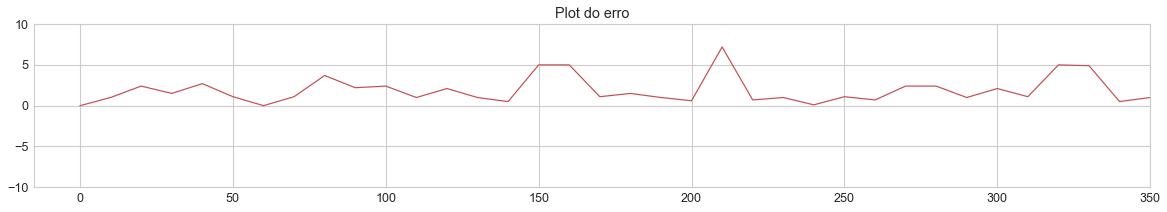

In [63]:
plotError(angles,outangles)

In [72]:
angles = np.arange(0,360,10)
outangles1 = []
start = time.time()
for i in angles: 
    sr, signal = wavfile.read("MultichannelSounds/interp/interp4/SoundMultichannel_" + str(i) + "_dist0.05_interp_4.wav")
    gccPhat1 = gcc_phat(signal[:,0], signal[:,2],sr)
    gccPhat2 = gcc_phat(signal[:,1], signal[:,2],sr)
    angle = getAngle((0.05,gccPhat1,gccPhat2))
    outangles1.append(angle)
end = time.time()
print(end - start)
print(outangles1)

C:\Users\twins\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\twins\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


26.708288192749023
[359.8, 9.0, 17.6, 28.5, 38.2, 51.1, 60.0, 68.9, 76.3, 91.5, 98.7, 111.0, 120.2, 129.0, 144.8, 148.3, 162.8, 171.1, 180.0, 189.0, 198.5, 212.8, 218.1, 231.0, 240.0, 248.9, 256.5, 267.1, 282.4, 291.0, 270.0, 308.9, 322.3, 331.7, 340.5, 351.0]


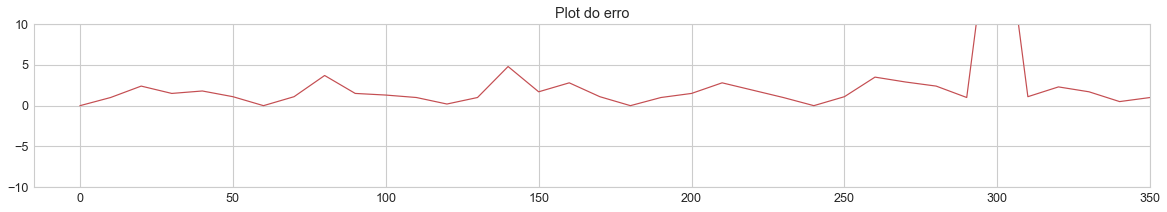

In [73]:
plotError(angles,outangles1)

In [66]:
angles = np.arange(0,360,10)
outangles2 = []
start = time.time()
for i in angles: 
    sr, signal = wavfile.read("MultichannelSounds/interp/interp8/SoundMultichannel_" + str(i) + "_dist0.05_interp_8.wav")
    gccPhat1 = gcc_phat(signal[:,0], signal[:,2],sr)
    gccPhat2 = gcc_phat(signal[:,1], signal[:,2],sr)
    angle = getAngle((0.05,gccPhat1,gccPhat2))
    outangles2.append(angle)
end = time.time()3
print(end - start)
print(outangles2)

C:\Users\twins\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\twins\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


44.280760765075684
[359.8, 12.2, 21.0, 27.8, 40.5, 51.1, 60.0, 70.8, 79.5, 89.6, 96.8, 111.0, 120.2, 129.0, 140.9, 148.7, 160.3, 171.1, 180.0, 189.0, 200.7, 210.4, 218.7, 231.0, 240.0, 248.9, 259.3, 269.7, 279.8, 288.9, 270.0, 308.9, 319.5, 331.3, 339.1, 347.8]


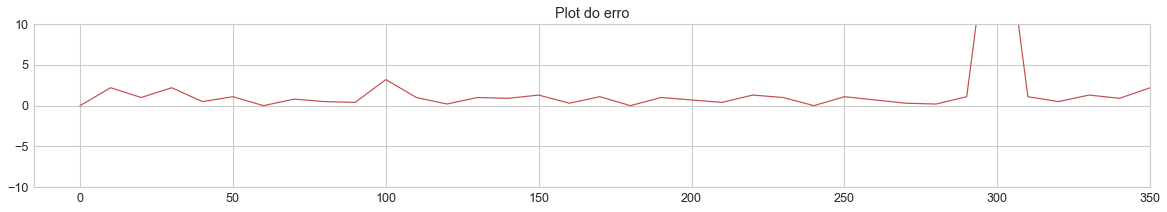

In [67]:
plotError(angles,outangles2)

In [92]:
angles = np.arange(0,360,10)
outangles3 = []
start = time.time()
for i in angles: 
    sr, signal = wavfile.read("MultichannelSounds/interp/interp10/SoundMultichannel_" + str(i) + "_dist0.05_interp_10.wav")
    gccPhat1 = gcc_phat(signal[:,0], signal[:,2],sr)
    gccPhat2 = gcc_phat(signal[:,1], signal[:,2],sr)
    angle = getAngle((0.05,gccPhat1,gccPhat2))
    outangles3.append(angle)
end = time.time()
print(end - start)
print(outangles3)

C:\Users\twins\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\twins\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


99.65872311592102
[360.0, 9.0, 18.3, 31.8, 40.5, 49.5, 61.7, 70.5, 78.8, 92.1, 100.2, 111.0, 120.0, 129.0, 141.3, 151.8, 160.3, 169.0, 180.1, 190.6, 200.1, 209.9, 218.7, 231.0, 240.0, 248.9, 261.2, 268.1, 280.3, 289.5, 298.4, 309.2, 319.7, 328.2, 341.4, 351.0]


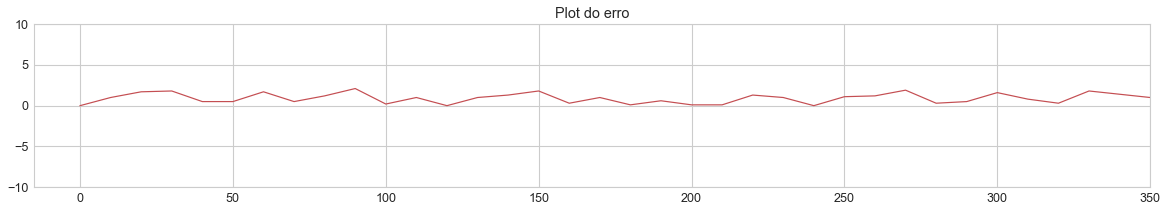

In [93]:
plotError(angles,outangles3)

In [84]:
angles = np.arange(0,360,10)
outangles4 = []
start = time.time()
for i in angles: 
    sr, signal = wavfile.read("MultichannelSounds/interp/interp5/SoundMultichannel_" + str(i) + "_dist0.05_interp_5.wav")
    gccPhat1 = gcc_phat(signal[:,0], signal[:,2],sr)
    gccPhat2 = gcc_phat(signal[:,1], signal[:,2],sr)
    angle = getAngle((0.05,gccPhat1,gccPhat2))
    outangles4.append(angle)
end = time.time()
print(end - start)
print(outangles4)

36.989426612854004
[359.8, 9.0, 19.8, 29.7, 40.4, 51.1, 60.0, 69.9, 79.6, 86.8, 100.2, 109.7, 120.0, 129.0, 139.8, 149.2, 160.3, 171.1, 180.0, 189.0, 199.7, 211.2, 220.4, 231.0, 240.0, 250.8, 259.8, 270.6, 280.3, 289.2, 270.0, 308.9, 319.7, 330.6, 340.2, 351.0]


[360.0, 7.4, 19.8, 31.8, 38.3, 49.5, 63.4, 70.5, 81.6, 88.2, 102.4, 109.4, 120.0, 127.4, 142.7, 151.8, 162.4, 169.0, 180.1, 190.6, 198.3, 209.9, 218.5, 233.1, 240.0, 251.1, 260.7, 270.2, 278.0, 289.5, 297.0, 309.2, 321.8, 328.2, 340.2, 352.6]


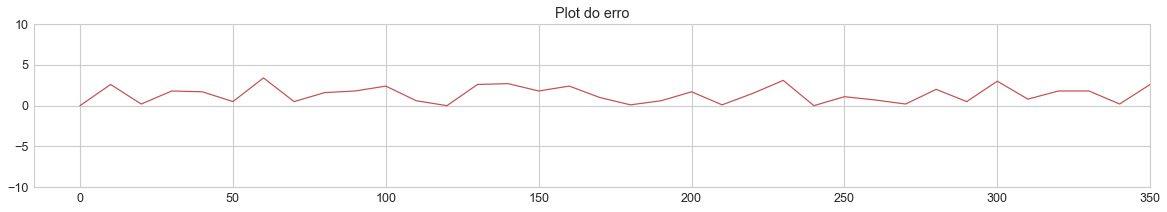

In [90]:
plotError(angles,outangles4)
print(outangles4)

In [95]:
angles = np.arange(0,360,10)
outangles5 = []
start = time.time()
for i in angles: 
    sr, signal = wavfile.read("MultichannelSounds/interp/interp1/SoundMultichannel_" + str(i) + "_dist0.05_interp_1.wav")
    gccPhat1 = gcc_phat(signal[:,0], signal[:,2],sr)
    gccPhat2 = gcc_phat(signal[:,1], signal[:,2],sr)
    angle = getAngle((0.05,gccPhat1,gccPhat2))
    outangles5.append(angle)
end = time.time()
print(end - start)
print(outangles5)

C:\Users\twins\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


5.159531354904175
[0.0, 17.6, 17.6, 36.3, 36.3, 60.0, 60.0, 60.0, 76.3, 102.4, 102.4, 102.4, 120.0, 120.0, 139.5, 150.0, 168.9, 160.6, 181.5, 196.3, 200.8, 216.3, 219.3, 240.0, 240.0, 260.7, 260.7, 260.7, 282.4, 298.5, 298.5, 298.5, 330.0, 330.0, 340.5, 340.5]


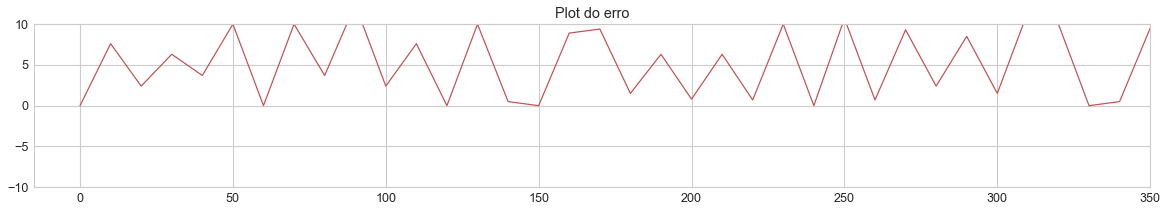

In [97]:
plotError(angles,outangles5)

In [115]:
angles = np.arange(0,360,10)
angles1 = []
for i in angles:
    sr, signal = wavfile.read("Sound_Multichannel_outNoise_angle"+str(i)+"_SNR25.wav")
    gccPhat1 = gcc_phat(signal[:,0], signal[:,2],sr)
    gccPhat2 = gcc_phat(signal[:,1], signal[:,2],sr)
    angle = getAngle((0.05,gccPhat1,gccPhat2))
    print(str(i)+" -> "+ str(angle))
    angles1.append(angle)  

0 -> 360.0
10 -> 0.0
20 -> 0.0
30 -> 31.8


C:\Users\twins\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


40 -> 38.3
50 -> 0.0
60 -> 120.0
70 -> 120.0
80 -> 81.6
90 -> 88.2
100 -> 120.0
110 -> 120.0
120 -> 120.0
130 -> 201.6
140 -> 126.3
150 -> 151.8
160 -> 180.0
170 -> 201.6
180 -> 180.1
190 -> 181.5
200 -> 182.8
210 -> 209.9
220 -> 218.5
230 -> 181.5
240 -> 240.0
250 -> 298.5
260 -> 260.7
270 -> 270.2
280 -> 297.2
290 -> 298.5
300 -> 297.0
310 -> 201.6
320 -> 306.3
330 -> 328.2
340 -> 355.5
350 -> 358.7


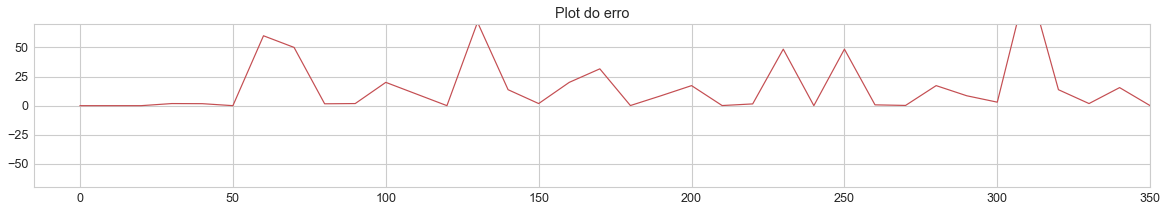

In [118]:
plotError(angles,angles1)

In [38]:
angles = np.arange(0,360,10)
angles2 = []
for i in angles:
    sr, signal = wavfile.read("MultichannelSounds/interp/interp2/SoundMultichannel_" + str(i) + "_dist0.05_interp_2.wav")
    gccPhat1 = gcc_phat(signal[:,0], signal[:,2],sr)
    gccPhat2 = gcc_phat(signal[:,1], signal[:,2],sr)
    angle = getAngle((0.05,gccPhat1,gccPhat2))
    print(str(i)+" -> "+ str(angle))
    angles2.append(angle)  

0 -> 0.0
10 -> 9.0


C:\Users\twins\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
C:\Users\twins\anaconda3\lib\site-packages\scipy\optimize\minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


20 -> 17.6
30 -> 28.5
40 -> 37.3
50 -> 51.1
60 -> 60.0
70 -> 68.9
80 -> 76.3
90 -> 92.2
100 -> 102.4
110 -> 111.0
120 -> 122.1
130 -> 129.0
140 -> 139.5
150 -> 145.0
160 -> 165.0
170 -> 171.1
180 -> 181.5
190 -> 189.0
200 -> 199.4
210 -> 217.2
220 -> 219.3
230 -> 231.0
240 -> 239.9
250 -> 248.9
260 -> 260.7
270 -> 272.4
280 -> 282.4
290 -> 291.0
300 -> 302.1
310 -> 308.9
320 -> 325.0
330 -> 334.9
340 -> 340.5
350 -> 351.0


tempo sinal fonte:  1.865578231292517

tempo sinal no Mic1:  1.8685260770975056
delay Mic1:  0.00295843079766588
tempo sinal no Mic2:  1.868390022675737
delay Mic2:  0.0028312900482230867
tempo sinal no Mic3:  1.8685260770975056
delay Mic3:  0.00295843079766588

diferença entre Mic1 e Mic2:  0.0001271407494427934
diferença entre Mic1 e Mic3:  0.0
diferença entre Mic2 e Mic3:  -0.0001271407494427934
tempo sinal fonte:  1.865578231292517

tempo sinal no Mic1:  1.8684807256235827
delay Mic1:  0.0029298819227090837
tempo sinal no Mic2:  1.868390022675737
delay Mic2:  0.002816925563526568
tempo sinal no Mic3:  1.8685260770975056
delay Mic3:  0.0029544383047893923

diferença entre Mic1 e Mic2:  0.00011295635918251576
diferença entre Mic1 e Mic3:  -2.4556382080308595e-05
diferença entre Mic2 e Mic3:  -0.00013751274126282435
tempo sinal fonte:  1.865578231292517

tempo sinal no Mic1:  1.8684807256235827
delay Mic1:  0.0029302377193733907
tempo sinal no Mic2:  1.868390022675737
delay Mic2:  0.0

C:\Users\twins\AppData\Local\Temp/ipykernel_18420/1185879743.py:36: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(5,5))


tempo sinal fonte:  1.865578231292517

tempo sinal no Mic1:  1.8684353741496598
delay Mic1:  0.002900688378627808
tempo sinal no Mic2:  1.8685714285714285
delay Mic2:  0.002993566156724003
tempo sinal no Mic3:  1.868390022675737
delay Mic3:  0.0028504381835654223

diferença entre Mic1 e Mic2:  -9.2877778096195e-05
diferença entre Mic1 e Mic3:  5.0250195062385896e-05
diferença entre Mic2 e Mic3:  0.0001431279731585809
tempo sinal fonte:  1.865578231292517

tempo sinal no Mic1:  1.8684807256235827
delay Mic1:  0.0029265366485188614
tempo sinal no Mic2:  1.8685714285714285
delay Mic2:  0.002998755655361675
tempo sinal no Mic3:  1.868390022675737
delay Mic3:  0.002853002588065476

diferença entre Mic1 e Mic2:  -7.221900684281374e-05
diferença entre Mic1 e Mic3:  7.353406045338545e-05
diferença entre Mic2 e Mic3:  0.0001457530672961992
tempo sinal fonte:  1.865578231292517

tempo sinal no Mic1:  1.8684807256235827
delay Mic1:  0.0029344937164799633
tempo sinal no Mic2:  1.8685260770975056
d

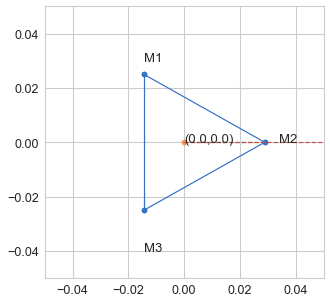

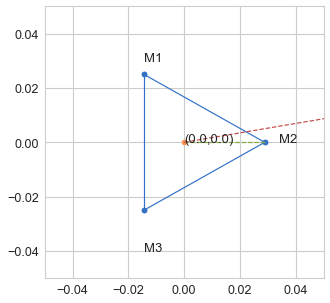

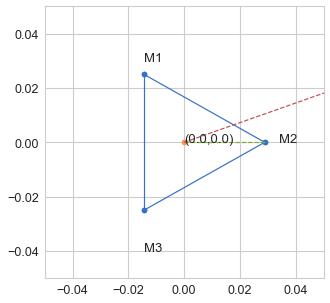

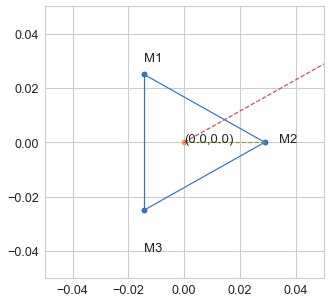

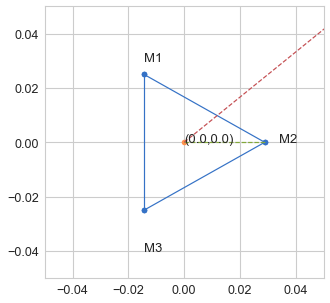

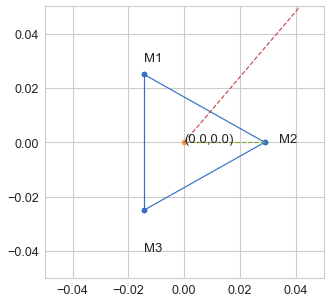

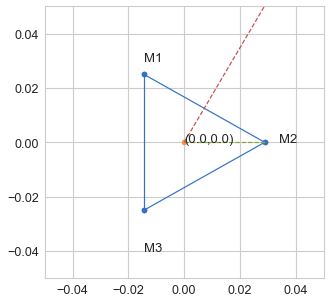

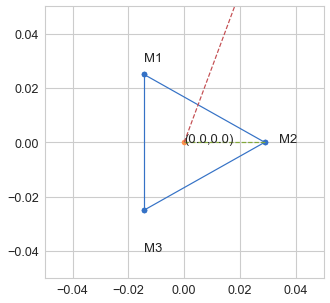

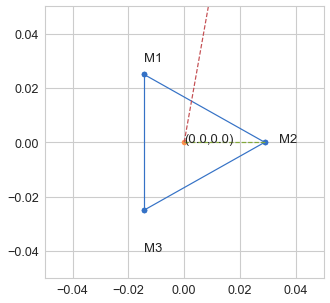

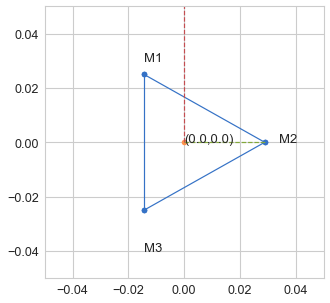

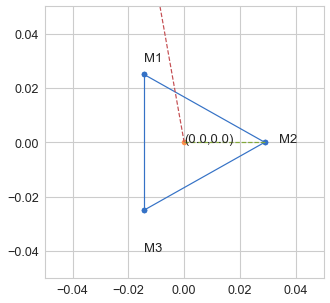

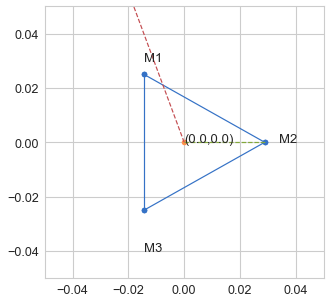

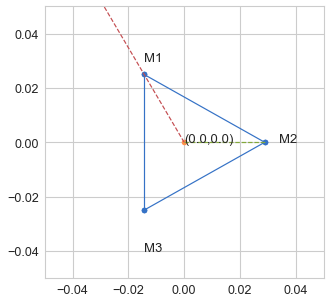

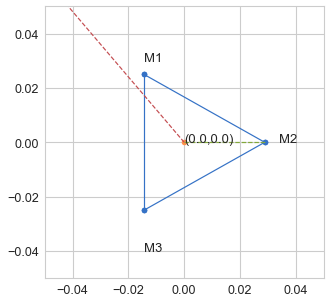

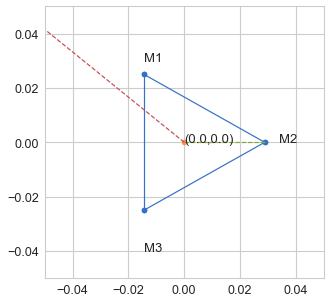

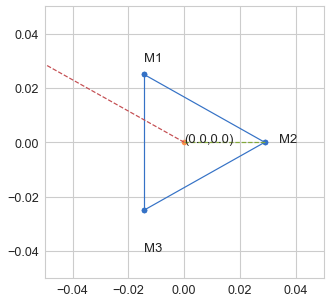

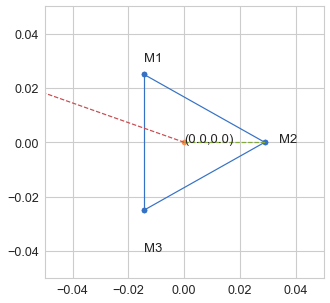

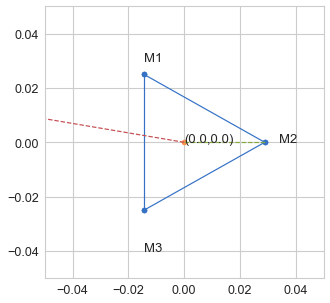

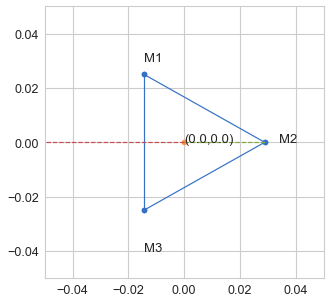

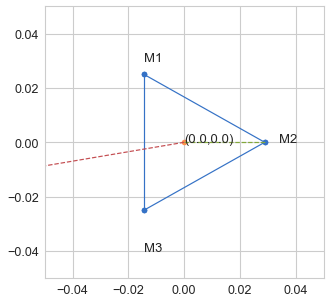

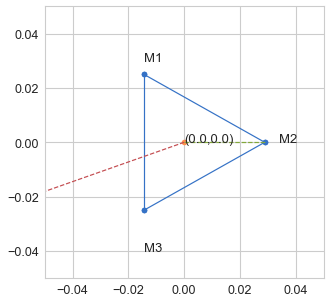

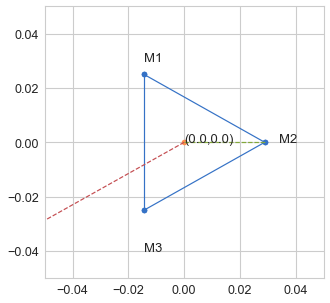

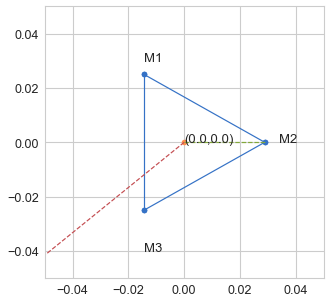

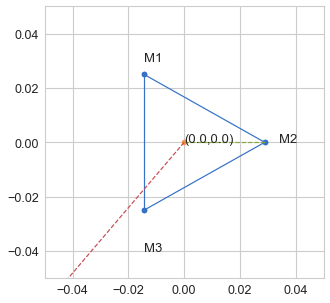

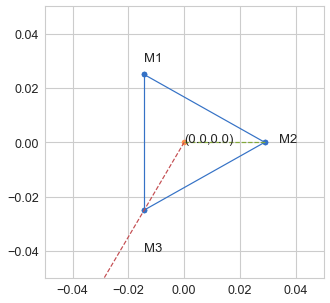

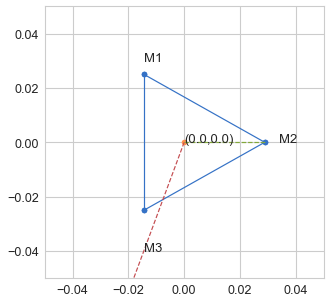

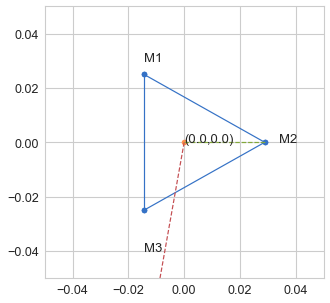

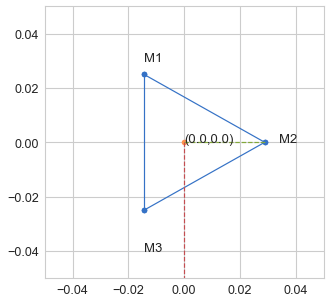

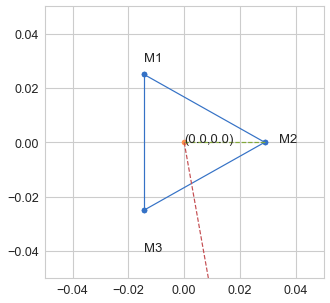

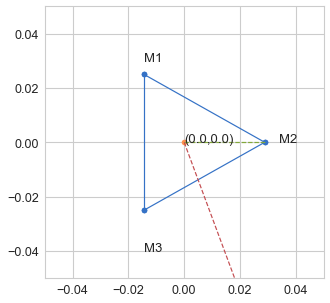

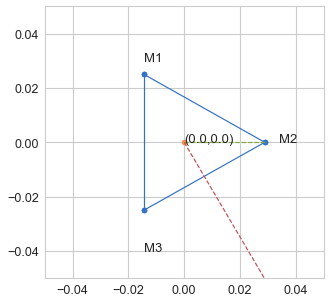

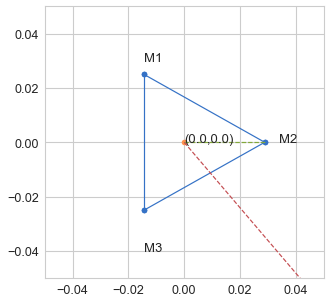

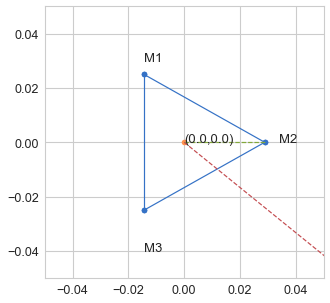

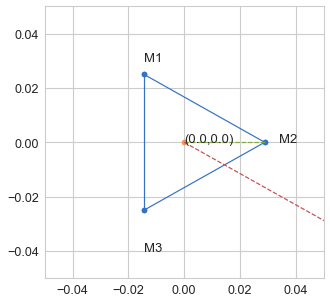

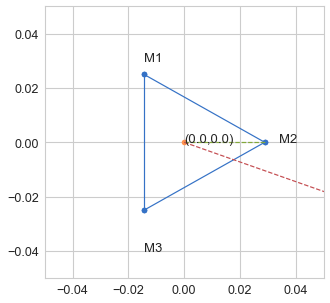

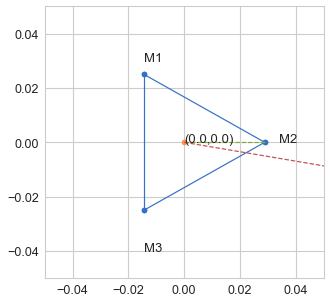

In [94]:
angles = np.arange(0,360,10)
interp = [2,4,8,12]
for i in angles:
    encodeMultichannel("RefSound/Sound.wav",i,1,d=0.05)

0
1
2


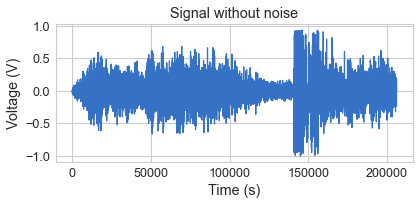

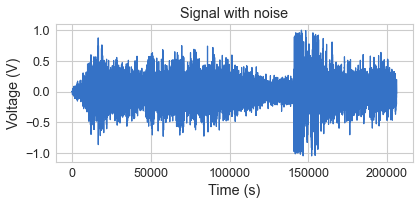

0
1
2


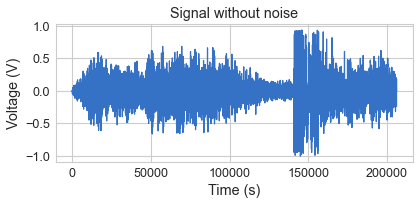

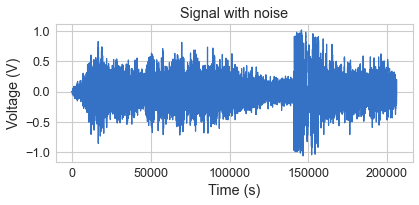

0
1
2


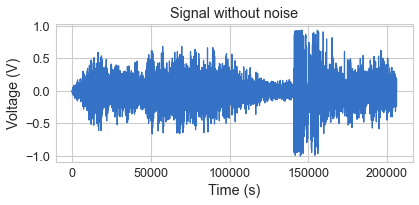

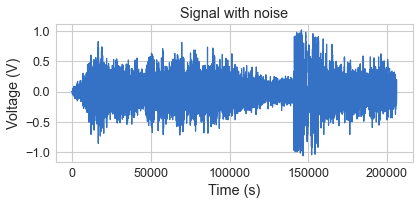

0
1
2


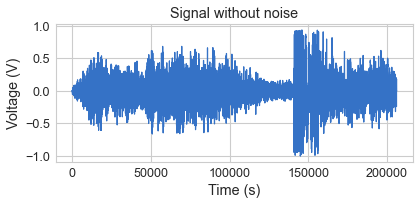

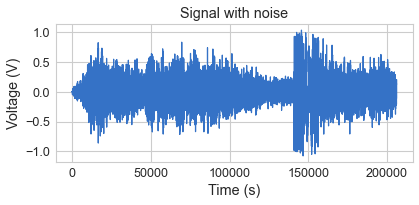

0
1
2


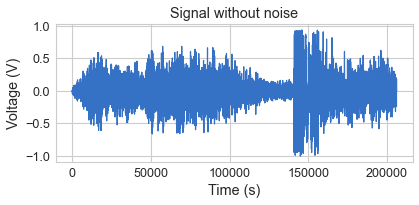

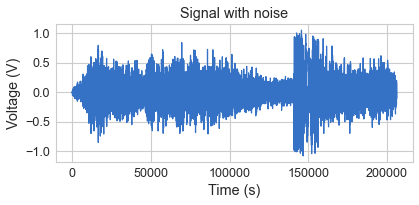

0
1
2


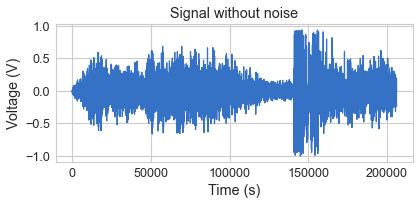

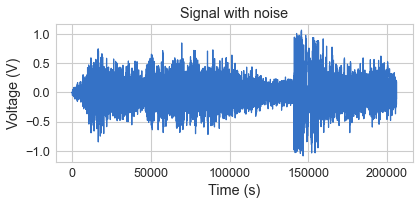

0
1
2


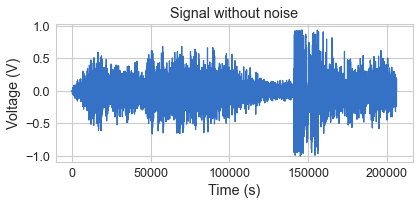

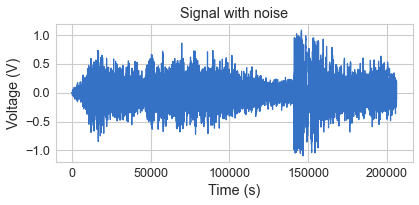

0
1
2


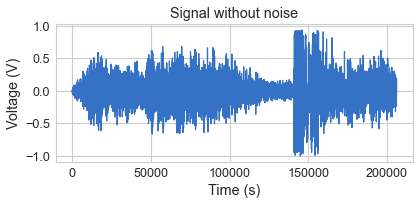

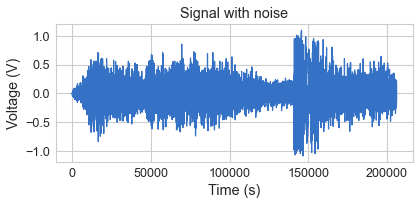

0
1
2


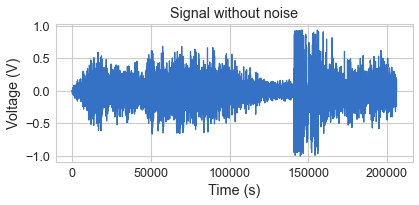

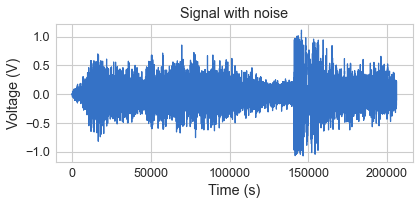

0
1
2


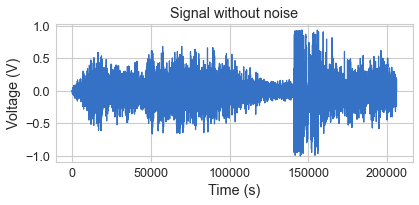

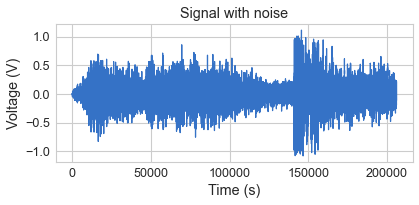

0
1
2


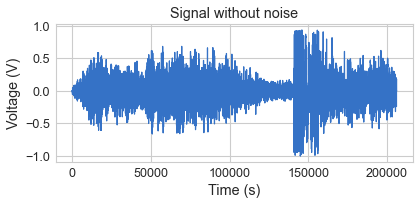

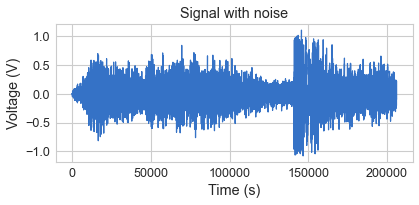

0
1
2


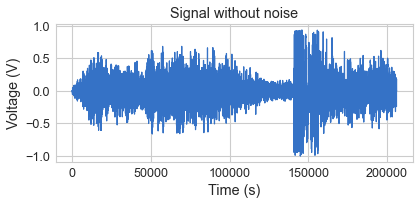

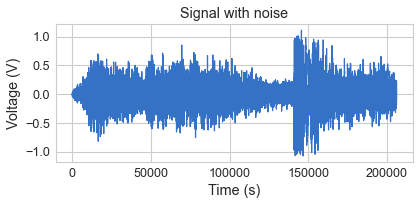

0
1
2


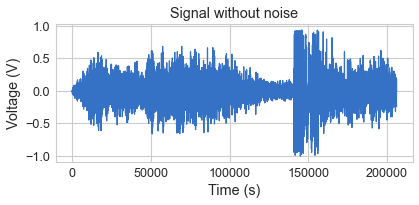

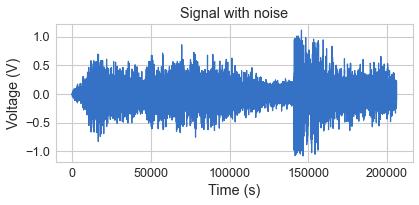

0
1
2


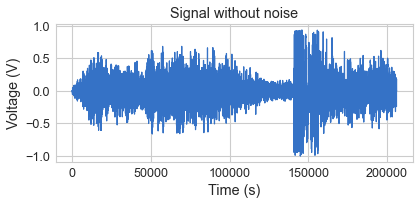

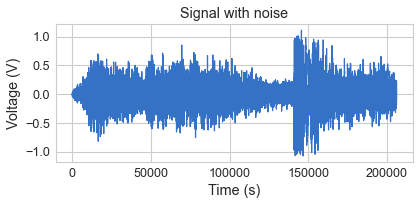

0
1
2


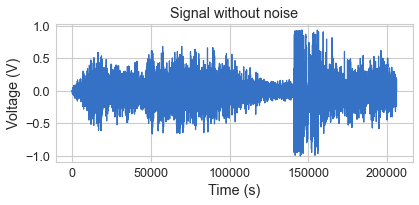

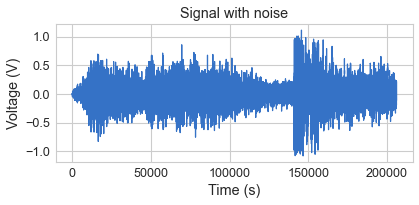

0
1
2


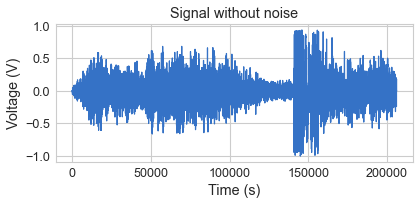

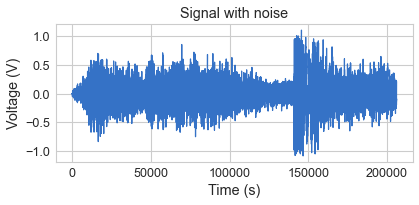

0
1
2


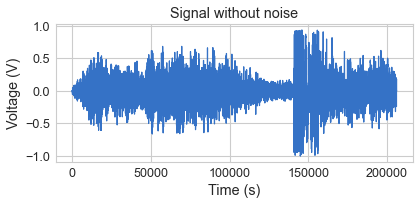

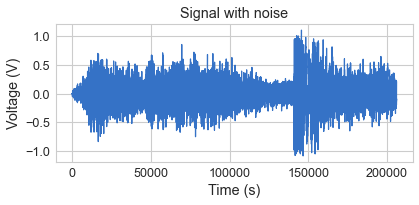

0
1
2


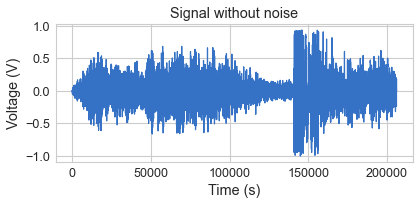

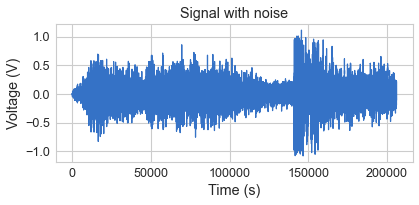

0
1
2


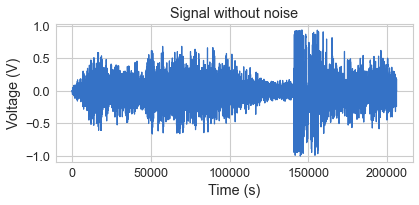

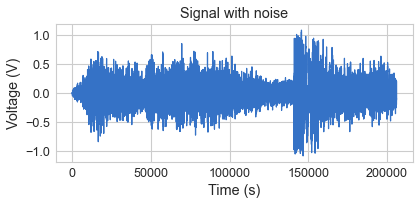

0
1
2


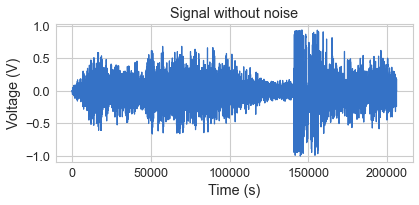

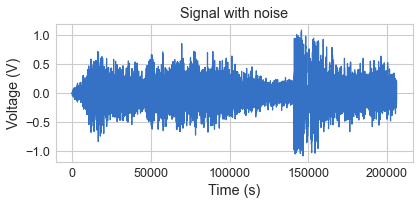

0
1
2


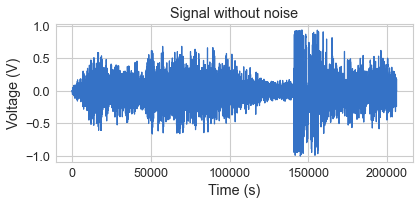

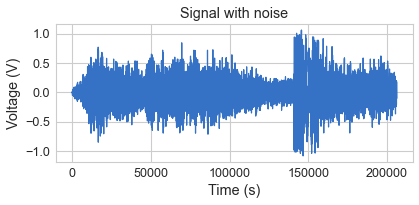

0
1
2


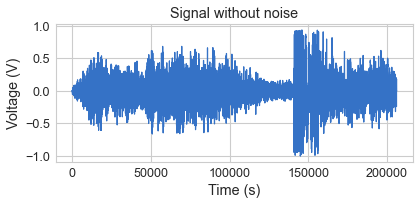

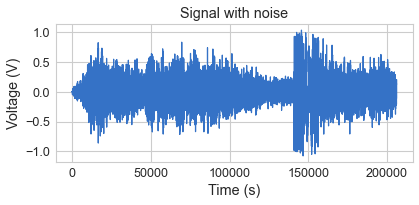

0
1
2


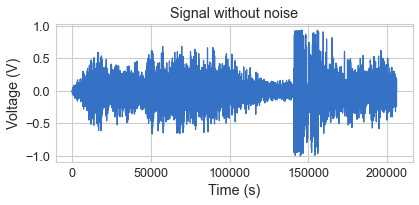

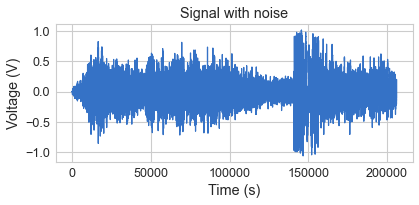

0
1
2


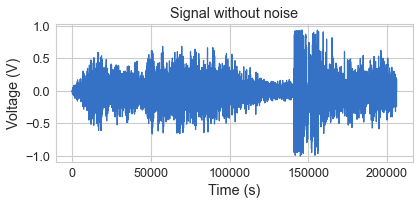

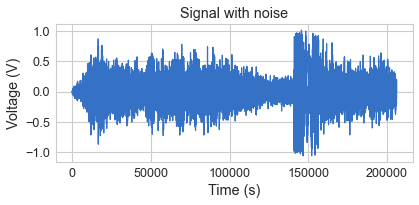

0
1
2


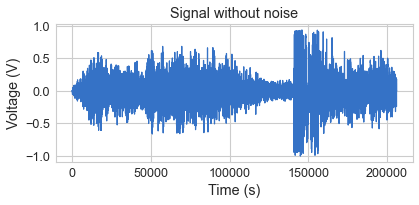

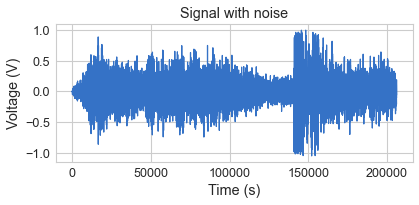

0
1
2


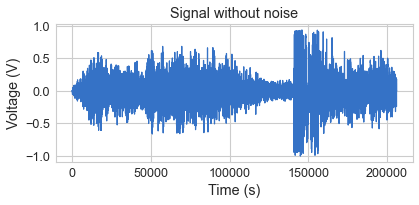

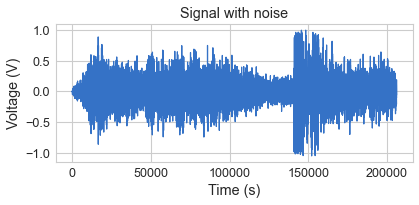

0
1
2


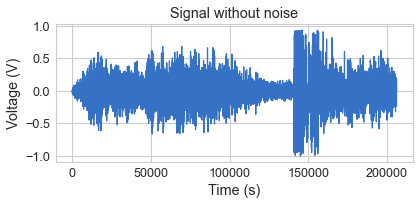

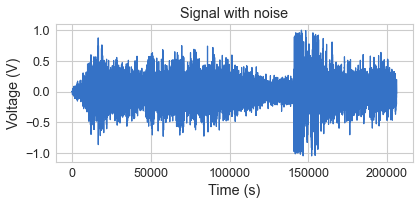

0
1
2


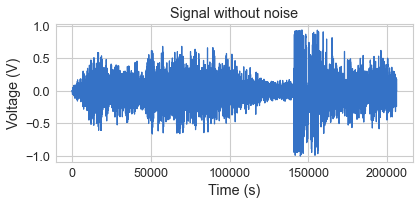

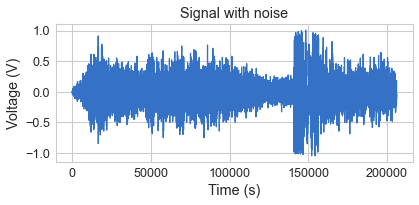

0
1
2


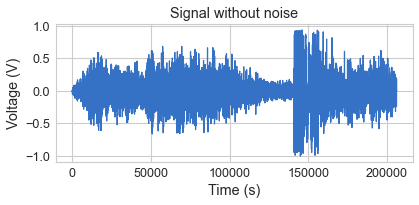

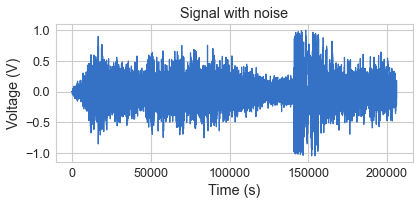

0
1
2


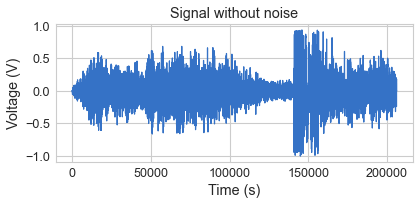

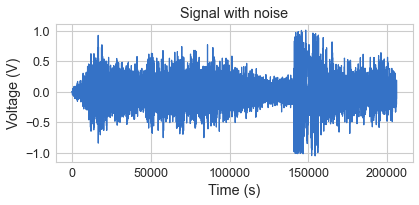

0
1
2


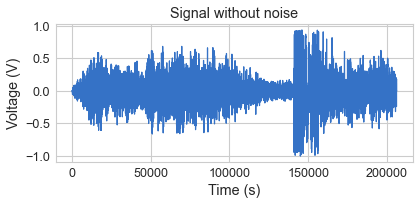

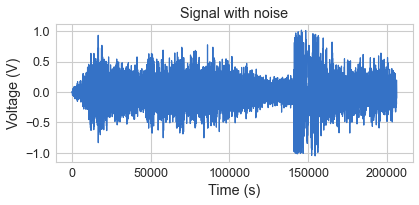

0
1
2


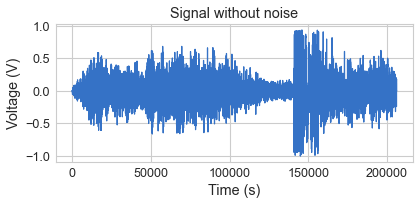

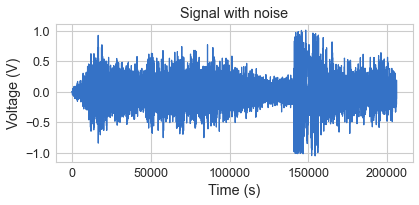

0
1
2


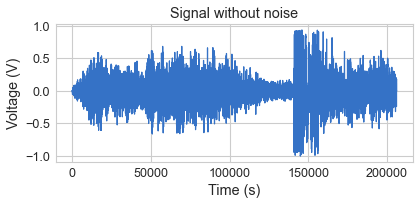

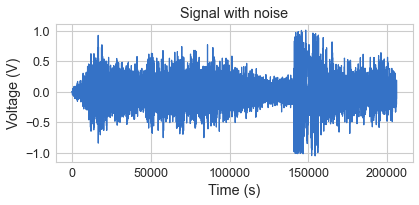

0
1
2


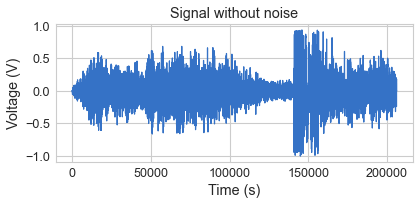

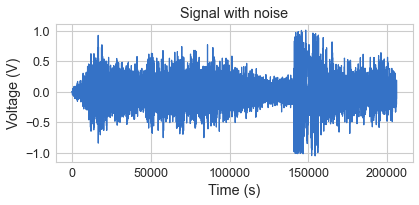

0
1
2


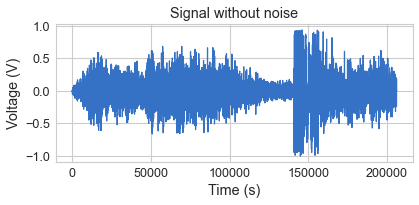

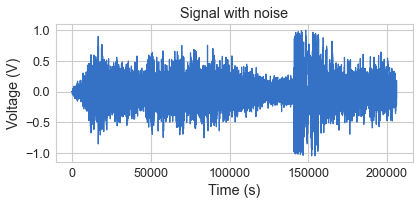

0
1
2


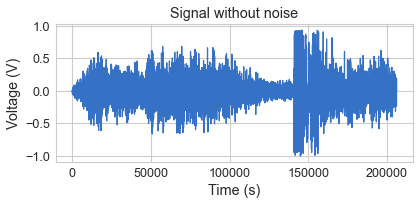

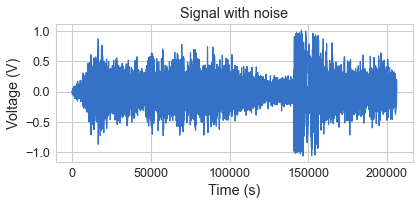

In [112]:
for i in angles:
    addNoise("MultichannelSounds/interp/interp5/SoundMultichannel_"+str(i)+"_dist0.05_interp_5.wav","outNoise",27,"outdoorNoise.wav",i)